In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
inspector=inspect(engine)
# inspect measurement dataset
print("-----\nmeasurement\n-----")
measurement_columns=inspector.get_columns('measurement')
for i in measurement_columns:
    print(i['name'],i['type'])

#inspect station dataset
print("-----\nstation\n-----")
station_columns=inspector.get_columns('station')
for i in station_columns:
    print(i['name'],i['type'])

-----
measurement
-----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
station
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#get last date point of database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
lastdate=dt.datetime.strptime(lastdate[0],'%Y-%m-%d')
print(f"Last date: {lastdate}")
#get start date (ie. 12 months before last date point)
startdate=lastdate-dt.timedelta(days=365)
print(f"First date: {startdate}")

Last date: 2017-08-23 00:00:00
First date: 2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
sel=[Measurement.date,Measurement.prcp] 
prcp_pastyear=session.query(*sel)\
    .filter(Measurement.date>=startdate)\
    .filter(Measurement.prcp.isnot(None)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_pastyear_df=pd.DataFrame(prcp_pastyear,columns=['date','precipitation'])
prcp_pastyear_df.set_index("date", inplace=True)

# Sort the dataframe by date
prcp_pastyear_df=prcp_pastyear_df.sort_values("date")

prcp_pastyear_df.head(10)

,precipitation
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,2.15
2016-08-25,0.21
2016-08-25,0.08
2016-08-25,0.00


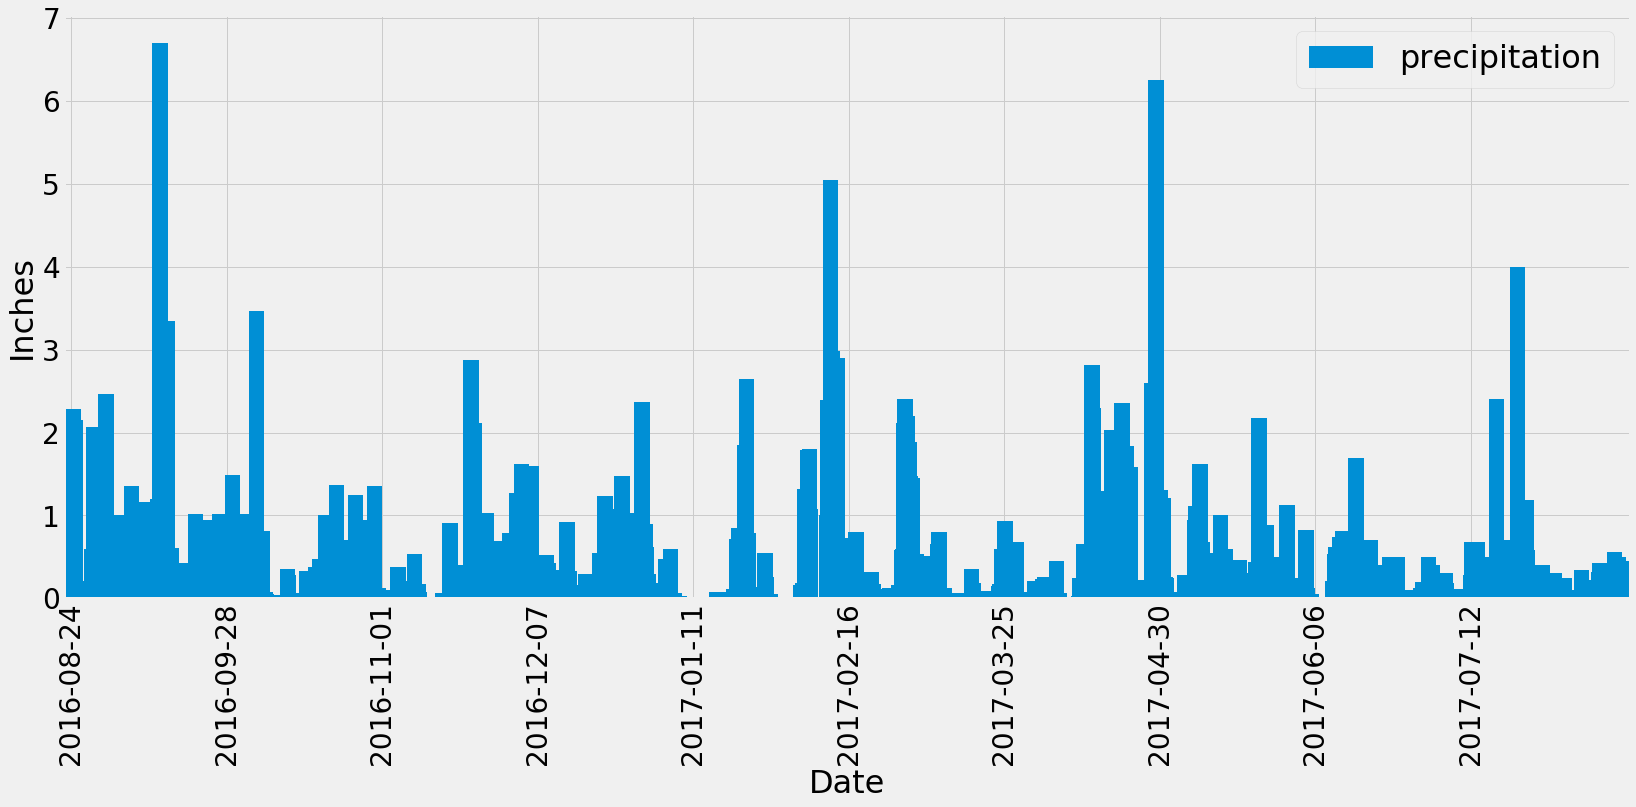

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
xtick=[prcp_pastyear_df.index[i] for i in range(len(prcp_pastyear_df.index)) if not i%202]

ax=prcp_pastyear_df["precipitation"].plot(
    kind="bar",rot=90,width=20,figsize=(25,10),
    xticks=[i for i in range(len(prcp_pastyear_df.index)) if not i%202])
ax.set_xticklabels(xtick)
ax.tick_params(labelsize=28)
ax.set_xlabel("Date",fontsize=32)
ax.set_ylabel("Inches",fontsize=32)
plt.legend(['precipitation'],fontsize=32)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_pastyear_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations=session.query(func.count(func.distinct(Measurement.station))).first()
print(f"There are {num_stations[0]} stations in this dataset.")

There are 9 stations in this dataset.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station,Station.name,func.count(Measurement.station))\
    .filter(Measurement.station==Station.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())

active_station_id=np.ravel(station_activity[0])[0]
active_station_name=np.ravel(station_activity[0])[1]
active_station_obs=np.ravel(station_activity[0])[2]
print(f"The most active station is {active_station_id}:{active_station_name}, with {active_station_obs} observations.")

station_activity_df=pd.DataFrame(station_activity,columns=["station id","name","observation counts"])
station_activity_df.set_index("station id", inplace=True)

station_activity_df

The most active station is USC00519281:WAIHEE 837.5, HI US, with 2772 observations.


,name,observation counts
station id,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp=session.query(func.min(Measurement.tobs),\
                           func.max(Measurement.tobs),\
                           func.avg(Measurement.tobs))\
                            .filter(Measurement.station==active_station_id).first()

station_temp=np.ravel(station_temp)
print(f"USC00519281\n-----\nmin temp = {station_temp[0]} F\nmax temp = {station_temp[1]} F\navg temp = {round(station_temp[2],1)} F")

USC00519281
-----
min temp = 54.0 F
max temp = 85.0 F
avg temp = 71.7 F


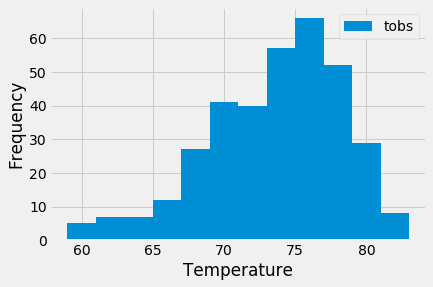

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp=session.query(Measurement.tobs)\
                .filter(Measurement.station==active_station_id)\
                .filter(Measurement.date>=startdate).all()
station_temp=np.ravel(station_temp)
plt.hist(station_temp,bins=12,label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend()

## Bonus Challenge Assignment

### Temperature Analysis I

In [19]:
# compare recorded temperature in June of all years vs Dec of all years
june_temp=session.query(Measurement.tobs)\
            .filter(func.strftime("%m",Measurement.date)=="06").all()
avg_june_temp=session.query(func.avg(Measurement.tobs))\
            .filter(func.strftime("%m",Measurement.date)=="06").first()

dec_temp=session.query(Measurement.tobs)\
            .filter(func.strftime("%m",Measurement.date)=="12").all()
avg_dec_temp=session.query(func.avg(Measurement.tobs))\
            .filter(func.strftime("%m",Measurement.date)=="12").first()

print(f"The average temperature in June is {round(avg_june_temp[0],2)}F.")
print(f"The average temperature in December is {round(avg_dec_temp[0],2)}F.")

The average temperature in June is 74.94F.
The average temperature in December is 71.04F.


In [20]:
# unpaired t-test comparing temperature between June and December
# as comparing across two independent samples
stat,p=stats.ttest_ind(june_temp,dec_temp,equal_var=False)
if p<0.05:
    print(f"There is a significant difference \
in recorded temperature between June and December, \
\nt={stat[0]}, p={p[0]}")

There is a significant difference in recorded temperature between June and December, 
t=31.355036920962423, p=4.193529835915755e-187


### Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_startdate=dt.datetime.strptime('2018-07-03','%Y-%m-%d')
trip_enddate=dt.datetime.strptime('2018-07-13','%Y-%m-%d')
prevyear_startdate=trip_startdate-dt.timedelta(days=365)
prevyear_enddate=trip_enddate-dt.timedelta(days=365)

trip_temp=calc_temps(prevyear_startdate,prevyear_enddate)
trip_temp=np.ravel(trip_temp)
print(f"Temperature between {dt.datetime.strftime(prevyear_startdate,'%Y-%m-%d')} \
and {dt.datetime.strftime(prevyear_enddate,'%Y-%m-%d')}\
\n-----\nmin temp = {trip_temp[0]}\navg temp = {trip_temp[1]}\nmax temp = {trip_temp[2]}")

Temperature between 2017-07-03 and 2017-07-13
-----
min temp = 69.0
avg temp = 77.859375
max temp = 82.0


Text(0.5, 1.0, 'Trip Avg Temp')

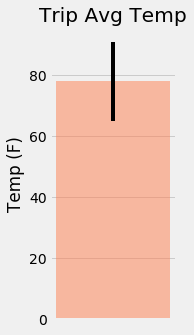

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(1,trip_temp[1],yerr=(trip_temp[2]-trip_temp[0]),color="coral",alpha=0.5)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_vars=[Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]

result=session.query(*query_vars)\
.filter(Measurement.station==Station.station)\
.filter(Measurement.date>=prevyear_startdate)\
.filter(Measurement.date<=prevyear_enddate)\
.filter(Measurement.prcp.isnot(None))\
.group_by(Measurement.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_trip_df=pd.DataFrame(result,columns=["Station ID","Station Name","Precipitation","Latitude","Longitude","Elevation"])
rainfall_trip_df

,Station ID,Station Name,Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.01,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.51,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.38,21.52130,-157.83740,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.11,21.27160,-157.81680,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.11,21.33556,-157.71139,19.5


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"trip start date={trip_startdate}")
print(f"trip end date={trip_enddate}")

# Use the start and end date to create a range of dates
daterange=pd.date_range(start=trip_startdate,end=trip_enddate)

# Stip off the year and save a list of %m-%d strings
daterange_noyear=[i.strftime("%m-%d") for i in daterange]

# Loop through the list of %m-%d strings and calculate the normals for each date
tmin=[]
tavg=[]
tmax=[]
for i in daterange_noyear:
    temp=np.ravel(daily_normals(i))
    tmin.append(temp[0])
    tavg.append(temp[1])
    tmax.append(temp[2])

trip start date=2018-07-03 00:00:00
trip end date=2018-07-13 00:00:00


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_df=pd.DataFrame({"date":daterange.astype(str),
                          "tmin":tmin,
                           "tavg":tavg,
                           "tmax":tmax})
trip_temp_df.set_index("date",inplace=True)
trip_temp_df

,tmin,tavg,tmax
date,,,
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0
2018-07-09,68.0,76.192982,83.0
2018-07-10,68.0,75.620690,82.0
2018-07-11,70.0,75.789474,81.0


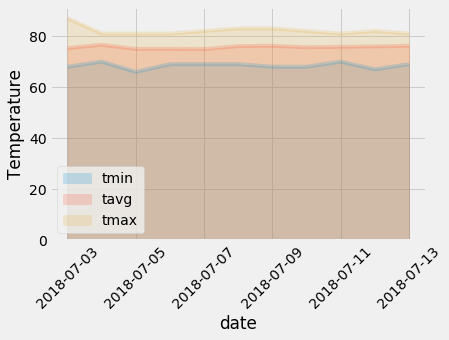

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_df.plot.area(stacked=False,alpha=0.2,rot=45)
plt.ylabel("Temperature")
plt.legend(loc="lower left")